## PIV basics inspection of different correlations methods

In the previous notebook "PIV basics 1" we tried to write our own analsys of two picture provided from the PIV challenge. We implemented our own correlation method computing the RMS of the difference between the pictures at different shifts wheres the minimum RMS would indicate the best fit ideally 0. We compared the results to clasic cross-correlation function thats built in scipy signal processing library.
We noticed the two correlation methods gave almost the same results except for three points, In this notebook we'll try to dig into it.
In the RMS function we wrote the size of the two pictures stayed the same after each shift for example, the last column becomes the first as ilustrated below:

<img src="matrix_rms1.png">

We'll try to implement it in adifferent way, if the last column moves one place forward we throw it away instead moving it to the first column:

<img src="matrix_rms2.png">

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate2d
# load the images: 
a = plt.imread('B005_1.tif')
b = plt.imread('B005_2.tif')
iw = 32
ia = a[:iw,:iw].copy()
ib = b[:iw,:iw].copy()   

now implement the new RMS function and the previous one:

In [2]:
def RMS2D_1(img, template,maxroll=8):
    #CALCULATES the RMS of the difference between img and template at different shifts of img
    #img-2d array of gray scale value of image at time t 
    #template-2d array of gray scale value of image at time t+dt
    #img and template should be same size
    #maxroll- maximun pixel shift of the img 8 pixels is the defult
    #last row/clumn that goes out of array bounds become the first/last row/column
    #i.e the shifted img stays at the same size
    #the function returns a 2d array C at size maxroll+1Xmaxroll+1 wherers
    #C[maxroll,maxroll]-Rms of the difference withount shifts img[i,j] tem[i,j]
    #C[maxroll+x,maxroll+y]-Rms of the difference with shifts img[i+x,j+y] tem[i,j]
    mindist = float('inf')
    idx = (0,0)
    cor=np.zeros((maxroll*2+1,maxroll*2+1))
    for row in range(-maxroll,maxroll+1):
        for col in range(-maxroll,maxroll+1):
            cor[maxroll+row,maxroll+col]=np.sqrt(np.sum(np.square(np.roll(img,(row,col),axis=(0,1)) - template)))                  
    return cor
#lets find the displacemant
def RMS2D_2(img, template, maxroll=8):
    #CALCULATES the RMS of the difference between img and template at different shifts of img
    #img-2d array of gray scale value of image at time t 
    #template-2d array of gray scale value of image at time t+dt
    #img and template should be same size
    #maxroll- maximun pixel shift of the img 8 pixels is the defult
    #last row/clumn that goes out of array bounds is thrown away
    #i.e the shifted img becomes smaller with each shift
    #the function returns a 2d array C at size maxroll+1Xmaxroll+1 wherers
    #C[maxroll,maxroll]-Rms of the difference withount shifts img[i,j] tem[i,j]
    #C[maxroll+x,maxroll+y]-Rms of the difference with shifts img[i+x,j+y] tem[i,j]
    cor=np.zeros((maxroll*2+1,maxroll*2+1))
    for row in range(maxroll+1):
        for col in range(maxroll+1):
            if col==0 and row==0:
                cor[maxroll,maxroll]=np.sqrt(np.sum(np.square(template - img)))
            elif col==0 and row!=0:
                cor[maxroll+row,maxroll]=np.sqrt(np.sum(np.square(template[row::,:] - np.roll(img,row,axis=0)[row::,:])))
                cor[maxroll-row,maxroll]=np.sqrt(np.sum(np.square(img[row::,:] - np.roll(template,row,axis=0)[row::,:])))
            elif row==0 and col!=0:
                cor[maxroll,maxroll+col]=np.sqrt(np.sum(np.square(template[:,col::] - np.roll(img,col,axis=1)[:,col::])))
                cor[maxroll,maxroll-col]=np.sqrt(np.sum(np.square(img[:,col::] - np.roll(template,col,axis=1)[:,col::])))
            else:
                cor[maxroll+row,maxroll+col]=np.sqrt(np.sum(np.square(template[row::,col::] - np.roll(img,(row,col),axis=(0,1))[row::,col::])))
                cor[maxroll-row,maxroll-col]=np.sqrt(np.sum(np.square(img[row::,col::] - np.roll(template,(row,col),axis=(0,1))[row::,col::])))
                cor[maxroll+row,maxroll-col]=np.sqrt(np.sum(np.square(np.roll(template,col,axis=1)[row::,col::] - np.roll(img,row,axis=0)[row::,col::])))
                cor[maxroll-row,maxroll+col]=np.sqrt(np.sum(np.square(np.roll(template,row,axis=0)[row::,col::] - np.roll(img,col,axis=1)[row::,col::])))
    return cor

We will also implement cross corelation function in order to self check ourselves if we really understand what scipy's function does:

In [3]:
def my_crosscor2d(img, template, maxroll=8):
    #CALCULATES the cross corelation  between img and template at different shifts of img
    #img-2d array of gray scale value of image at time t 
    #template-2d array of gray scale value of image at time t+dt
    #img and template should be same size
    #maxroll- maximun pixel shift of the img 8 pixels is the defult
    #last row/clumn that goes out of array bounds is thrown away
    #i.e the shifted img becomes smaller with each shift
    #the function returns a 2d array C at size maxroll+1Xmaxroll+1 wherers
    #C[maxroll,maxroll]-cross corelation  withount shifts img[i,j] X tem[i,j]
    #C[maxroll+x,maxroll+y]-cross corelation with shifts img[i+x,j+y] X tem[i,j]    
    cor=np.zeros((maxroll*2+1,maxroll*2+1))
    for row in range(maxroll+1):
        for col in range(maxroll+1):
            if col==0 and row==0:
                cor[maxroll,maxroll]=np.sum(template * img)
            elif col==0 and row!=0:
                cor[maxroll+row,maxroll]=np.sum(template[row::,:] * np.roll(img,row,axis=0)[row::,:])
                cor[maxroll-row,maxroll]=np.sum(img[row::,:] * np.roll(template,row,axis=0)[row::,:])
            elif row==0 and col!=0:
                cor[maxroll,maxroll+col]=np.sum(template[:,col::] * np.roll(img,col,axis=1)[:,col::])
                cor[maxroll,maxroll-col]=np.sum(img[:,col::] * np.roll(template,col,axis=1)[:,col::])
            else:
                cor[maxroll+row,maxroll+col]=np.sum(template[row::,col::] * np.roll(img,(row,col),axis=(0,1))[row::,col::])
                cor[maxroll-row,maxroll-col]=np.sum(img[row::,col::] * np.roll(template,(row,col),axis=(0,1))[row::,col::])
                cor[maxroll+row,maxroll-col]=np.sum(np.roll(template,col,axis=1)[row::,col::] * np.roll(img,row,axis=0)[row::,col::])
                cor[maxroll-row,maxroll+col]=np.sum(np.roll(template,row,axis=0)[row::,col::] * np.roll(img,col,axis=1)[row::,col::])
    return cor


RMS1:4,-7
RMS2:4,-7
my cross corelation:4,-7
scipy cross corelation:4,-7


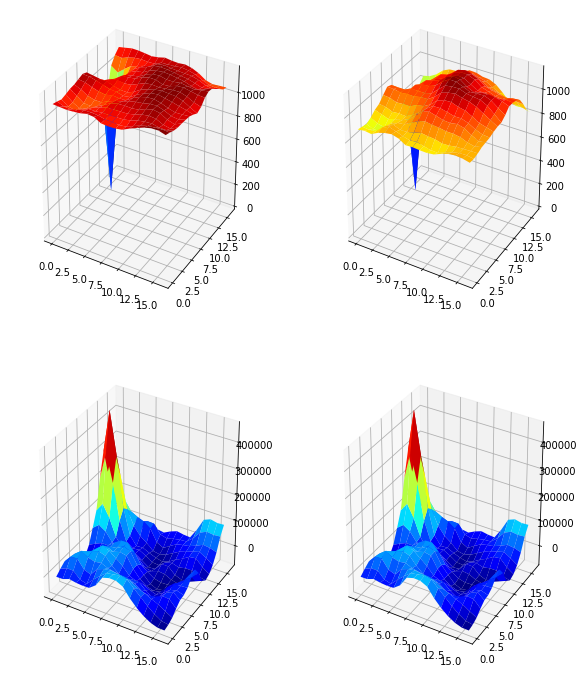

In [21]:
# let's test that it works indeed by manually rolling (shifting circurlarly) the same image
cor1 =RMS2D_1(ia-ia.mean(),np.roll(ia,(4,-7),axis=(0,1))-ia.mean())
i,j = np.unravel_index(cor1.argmin(), cor1.shape)
print('RMS1:%d,%d'%(i-8,j-8))
cor2=RMS2D_2(ia-ia.mean(),np.roll(ia,(4,-7),axis=(0,1))-ia.mean())
i,j = np.unravel_index(cor2.argmin(), cor2.shape)
print('RMS2:%d,%d'%(i-8,j-8))
cor3=my_crosscor2d(ia-ia.mean(),np.roll(ia,(4,-7),axis=(0,1))-ia.mean())
i,j = np.unravel_index(cor3.argmax(), cor3.shape)
print('my cross corelation:%d,%d'%(i-8,j-8))
cor4 = correlate2d(np.roll(ia,(4,-7),axis=(0,1))-ia.mean(),np.roll(ia,(0,0),axis=(0,1))-ia.mean())
i,j = np.unravel_index(cor4[31-8:32+8,31-8:32+8].argmax(), cor4[31-8:32+8,31-8:32+8].shape)
print('scipy cross corelation:%d,%d'%(i-8,j-8))
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
x=np.arange(8*2+1)
y=np.arange(8*2+1)
X,Y=np.meshgrid(x,y)
surf1 = ax1.plot_surface(X, Y, cor1, cmap='jet')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, cor2, cmap='jet')
ax3 = fig.add_subplot(2,2, 3, projection='3d')
surf3 = ax3.plot_surface(X, Y, cor3, cmap='jet')
ax4 = fig.add_subplot(2,2, 4, projection='3d')
surf4 = ax4.plot_surface(X, Y, cor4[iw-1-8:iw+8,iw-1-8:iw+8], cmap='jet')

OK, seems OK lets try it to compare ia and ib:

RMS1:-1,1
RMS2:-1,1
my cross cor:-1,1
scipy cross cor:-1,1


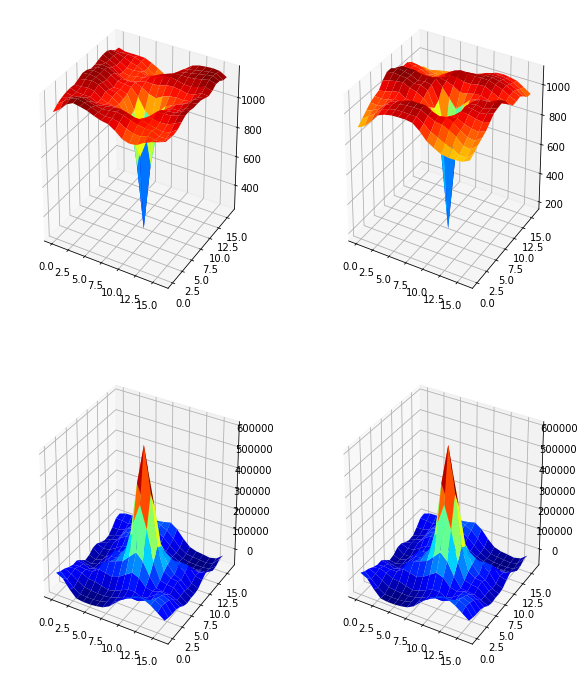

In [22]:
cor1= RMS2D_1(ia-ia.mean(),ib-ib.mean())
i,j = np.unravel_index(cor1.argmin(), cor1.shape)
print('RMS1:%d,%d'%(i-8,j-8))
cor2 =RMS2D_2(ia-ia.mean(),ib-ib.mean())
i,j = np.unravel_index(cor2.argmin(), cor2.shape)
print('RMS2:%d,%d'%(i-8,j-8))
cor3 = my_crosscor2d(ia-ia.mean(),ib-ib.mean())
i,j = np.unravel_index(cor3.argmax(), cor3.shape)
print('my cross cor:%d,%d'%(i-8,j-8))
cor4 = correlate2d(ib-ib.mean(),ia-ia.mean())
i,j = np.unravel_index(cor4.argmax(), cor4.shape)
print('scipy cross cor:%d,%d'%(i-31,j-31))

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
x=np.arange(8*2+1)
y=np.arange(8*2+1)
X,Y=np.meshgrid(x,y)
surf1 = ax1.plot_surface(X, Y, cor1, cmap='jet')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, cor2, cmap='jet')
ax3 = fig.add_subplot(2,2, 3, projection='3d')
surf3 = ax3.plot_surface(X, Y, cor3, cmap='jet')
ax4 = fig.add_subplot(2,2, 4, projection='3d')
surf4 = ax4.plot_surface(X, Y, cor4[iw-1-8:iw+8,iw-1-8:iw+8], cmap='jet')

seems we got the same results, lets run the analasys on the whole images:


In [15]:
x,y,u_rms1,v_rms1,u_cor,v_cor,u_rms2,v_rms2,u_mycross,v_mycross = [],[],[],[],[],[],[],[],[],[]
for k in range(0,a.shape[0],iw):
    for m in range(0,a.shape[1],iw):
        ia = a[k:k+iw,m:m+iw].copy()
        ib = b[k:k+iw,m:m+iw].copy()
        cor_rms1 = RMS2D_1(ia-ia.mean(),ib-ib.mean())
        row,col = np.unravel_index(cor_rms1.argmin(), cor_rms1.shape)
        y.append(k+iw/2.-1)
        x.append(m+iw/2.-1)
        u_rms1.append(col-8)
        v_rms1.append(row-8)
        cor = correlate2d(ib-ib.mean(),ia-ia.mean())
        cor=cor[iw-1-8:iw+8,iw-1-8:iw+8]
        row,col = np.unravel_index(cor.argmax(), cor.shape)
        u_cor.append(col-8)
        v_cor.append(row-8)
        c_rms2 = RMS2D_2(ia-ia.mean(),ib-ib.mean())
        row,col = np.unravel_index(c_rms2.argmin(), c_rms2.shape)
        u_rms2.append(col -8)
        v_rms2.append(row- 8)
        c_mycross = my_crosscor2d(ia-ia.mean(),ib-ib.mean())
        row,col = np.unravel_index(c_mycross.argmax(), c_mycross.shape)
        u_mycross.append(col -8)
        v_mycross.append(row- 8)

Text(0.5,1,'my cross cor')

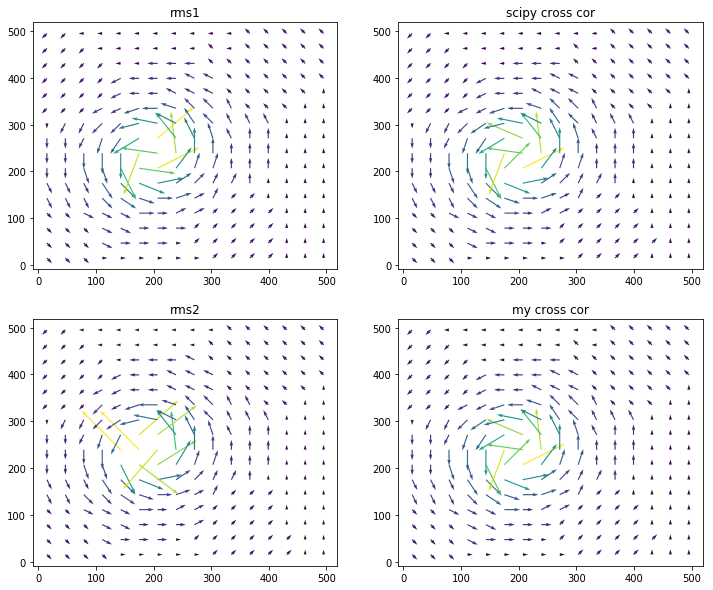

In [16]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
M_rms1 = np.sqrt(pow(np.array(u_rms1), 2) + pow(np.array(v_rms1), 2))
plt.quiver(x,y,u_rms1,v_rms1,M_rms1)
plt.title('rms1')

plt.subplot(2,2,2)
M_cor = np.sqrt(pow(np.array(u_cor), 2) + pow(np.array(v_cor), 2))
plt.quiver(x,y,u_cor,v_cor,M_cor)
plt.title('scipy cross cor')

plt.subplot(2,2,3)
M_rms2 = np.sqrt(pow(np.array(u_rms2), 2) + pow(np.array(v_rms2), 2))
plt.quiver(x,y,u_rms2,v_rms2,M_rms2)
plt.title('rms2')

plt.subplot(2,2,4)
M_mycross = np.sqrt(pow(np.array(u_mycross), 2) + pow(np.array(v_mycross), 2))
plt.quiver(x,y,u_mycross,v_mycross,M_mycross)
plt.title('my cross cor')

In [17]:
q_rms1_rms2= np.array(M_dif)==np.array(M_my)
problem_rms1_rms2=np.where(q_rms1_rms2==False)
q_mycrosscor_corsscor= np.array(M_mycross)==np.array(M_cor)
problem_mycrosscor_corsscor=np.where(q_mycrosscor_corsscor==False)
print('number of different points comparing rms1 to rms2:%d'%np.size(problem_rms1_rms2[0]))
print('number of different points coparing my cross cor to scipys:%d'%np.size(problem_mycrosscor_corsscor[0]))

number of different points comparing rms1 to rms2:25
number of different points coparing my cross cor to scipys:0


1.We managed to implement cross corelation function right

2.changing the size of the images after each shift, which seemed to be amore physically oriented aproach, performed poorly. 